In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# File path
file_path = r"C:\Users\saksh\Downloads\Analytics Live\synthetic_hourly_energy_data.csv"

# Define dtype_map (no change from original)
dtype_map = {
    'Consumption (Wh)': 'float32',
    'Seasonal Factor': 'float32',
    'Standard (Electric Ireland)': 'float32',
    'Dynamic (Electric Ireland)': 'float32',
    'ToU (Electric Ireland)': 'float32',
    'Standard (Bord Gáis)': 'float32',
    'Dynamic (Bord Gáis)': 'float32',
    'ToU Bord Gais': 'float32',
    'Minute Bill Standard EI': 'float32',
    'Minute Bill Dynamic EI': 'float32',
    'Minute Bill ToU EI': 'float32',
    'Minute Bill Standard BG': 'float32',
    'Minute Bill Dynamic BG': 'float32',
    'Minute Bill ToU BG': 'float32'
}

# Read file in chunks if needed (optional):
df = pd.read_csv(file_path, dtype=dtype_map, parse_dates=['Date'])

# Preprocess
df.dropna(inplace=True)
df = df.sort_values(by=['Date', 'Household_ID'])

# Rename billing columns from "Minute Bill" to "Hour Bill"
df = df.rename(columns={
    'Minute Bill Standard EI': 'Hour Bill Standard EI',
    'Minute Bill Dynamic EI': 'Hour Bill Dynamic EI',
    'Minute Bill ToU EI': 'Hour Bill ToU EI',
    'Minute Bill Standard BG': 'Hour Bill Standard BG',
    'Minute Bill Dynamic BG': 'Hour Bill Dynamic BG',
    'Minute Bill ToU BG': 'Hour Bill ToU BG'
})


C:\Users\saksh\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\saksh\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - loss: 0.0060 - mae: 0.0467
Epoch 2/50
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 72s 42ms/step - loss: 9.2824e-04 - mae: 0.0218
Epoch 3/50
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 71s 41ms/step - loss: 6.7515e-04 - mae: 0.0190
Epoch 4/50
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - loss: 6.8092e-04 - mae: 0.0193
Epoch 5/50
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 75s 44ms/step - loss: 6.1988e-04 - mae: 0.0186
Epoch 6/50
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 76s 44ms/step - loss: 5.8437e-04 - mae: 0.0181
Epoch 7/50
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 74s 43ms/step - loss: 5.9150e-04 - mae: 0.0182
Epoch 8/50
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 73s 43ms/step - loss: 5.9256e-04 - mae: 0.0183
Epoch 9/50
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 75s 44ms/step - loss: 5.8525e-04 - mae: 0.0181
Epoch 10/50
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 73s 42ms/step - loss: 5.6549e-04 - mae: 0.0178
Epoch 11/50
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 71s 42ms/step - loss: 5.3512e-04 - mae: 0.0174
Epoch 12/50
1711/1711 ━

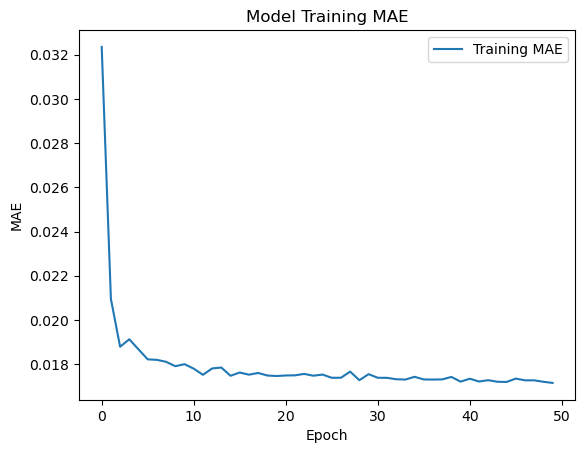

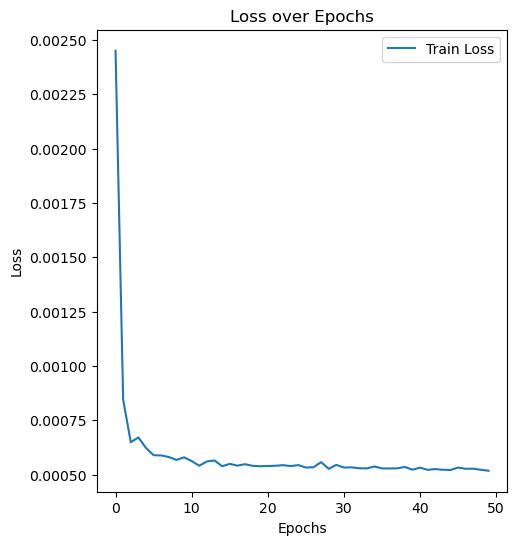

In [2]:
from sklearn.model_selection import train_test_split

# Encode categorical columns
df['Household'] = LabelEncoder().fit_transform(df['Household'].astype(str))
df['Day Type'] = LabelEncoder().fit_transform(df['Day Type'].astype(str))

# Define features and targets (no Household Size now)
features = [
    'Consumption (Wh)', 'Seasonal Factor',
    'Standard (Electric Ireland)', 'Dynamic (Electric Ireland)', 'ToU (Electric Ireland)',
    'Standard (Bord Gáis)', 'Dynamic (Bord Gáis)', 'ToU Bord Gais'
]

targets = [
    'Hour Bill Standard EI', 'Hour Bill Dynamic EI', 'Hour Bill ToU EI',
    'Hour Bill Standard BG', 'Hour Bill Dynamic BG', 'Hour Bill ToU BG'
]

# Normalize features + targets
scaler = MinMaxScaler()
df[features + targets] = scaler.fit_transform(df[features + targets])

# Sequence parameters
SEQ_LENGTH = 12
BATCH_SIZE = 512
all_columns = features + targets



# Prepare TimeseriesGenerator
data = df[all_columns].astype(np.float32).to_numpy()  # Ensures float32 type
target_idx = list(range(len(features), len(features) + len(targets)))
generator = TimeseriesGenerator(
    data, data[:, target_idx],
    length=SEQ_LENGTH,
    batch_size=BATCH_SIZE
)

# Reshape for LSTM
#data = data.values.reshape((data.shape[0], 1, data.shape[1]))

# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data, target_idx, test_size=0.2, random_state=42)

# Build model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, data.shape[1])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(len(targets), activation='linear')
])

# Compile and train
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(generator, epochs=50)

# Predict
predictions = model.predict(generator)
optimal_indices = np.argmin(predictions, axis=1)
plan_labels = ['Standard EI', 'Dynamic EI', 'ToU EI', 'Standard BG', 'Dynamic BG', 'ToU BG']
optimal_plans = [plan_labels[i] for i in optimal_indices]

# Show sample predictions
#print("\nTop 10 Optimal Tariff Predictions:")
#for i in range(10):
#   print(f"Plan: {optimal_plans[i]} | Cost: €{min(predictions[i]):.4f}")

# Save model
model.save("lstm_tariff_predictor.keras")
print("\nModel saved successfully!")

# Plot MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.title('Model Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


# Plot training and validation metrics
plt.figure(figsize=(18, 6))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MAE plot
#plt.subplot(1, 3, 2)
#plt.plot(history.history['mae'], label='Train MAE')
#plt.plot(history.history['val_mae'], label='Validation MAE')
#plt.title('Mean Absolute Error over Epochs')
#plt.xlabel('Epochs')
#plt.ylabel('MAE')
#plt.legend()

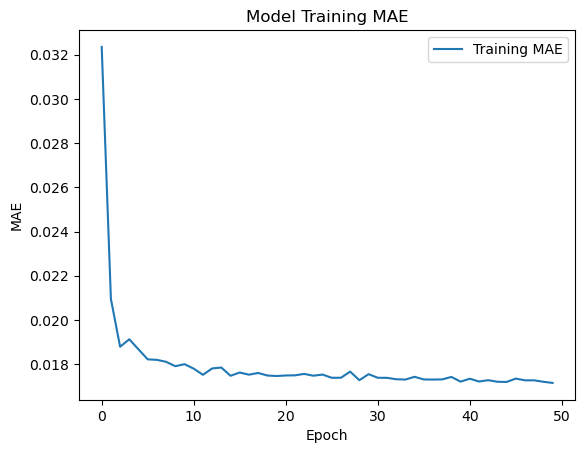

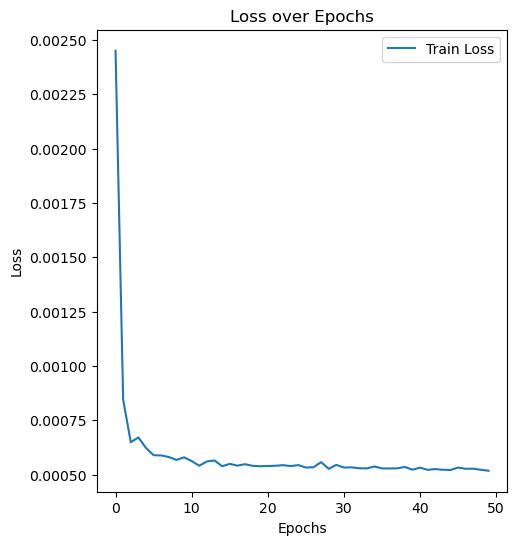

In [3]:
# Plot MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.title('Model Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


# Plot training and validation metrics
plt.figure(figsize=(18, 6))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MAE plot
#plt.subplot(1, 3, 2)
#plt.plot(history.history['mae'], label='Train MAE')
#plt.plot(history.history['val_mae'], label='Validation MAE')
#plt.title('Mean Absolute Error over Epochs')
#plt.xlabel('Epochs')
#plt.ylabel('MAE')
#plt.legend()

In [16]:
# --- User Input Section --- 
# --- User Input ---
annual_consumption_kwh = float(input("Enter your approximate annual energy consumption in kWh (e.g., 4200): "))
location_type = input("Is your home in 'urban' or 'rural' area? ").strip().lower()
h = int(input("Enter household size: "))
# Optional: Add a random seed to vary the input pattern
#seed_input = input("Enter a random seed for testing variation (press enter to skip): ").strip()
#if seed_input:
    #np.random.seed(int(seed_input))

# Simulate 24-hour usage profile
daily_kwh = annual_consumption_kwh / 365
hourly_wh = (daily_kwh * 1000) / 24

# Realistic hourly shape
hour_factors = np.array([0.4]*6 + [0.6]*4 + [1.0]*6 + [1.2]*4 + [0.8]*4)
hour_factors = hour_factors / hour_factors.sum() * 24
consumption_pattern = hourly_wh * hour_factors * np.random.normal(1.0, 0.1, 24)
consumption_pattern = np.clip(consumption_pattern, 0, None)

# Use actual average tariffs from the dataset
tariff_factors = [
    df["Standard (Electric Ireland)"].mean(),
    df["Dynamic (Electric Ireland)"].mean(),
    df["ToU (Electric Ireland)"].mean(),
    df["Standard (Bord Gáis)"].mean(),
    df["Dynamic (Bord Gáis)"].mean(),
    df["ToU Bord Gais"].mean()
]

# Prepare model input
seasonal_factor = np.full(24, 1.0)
tariff_matrix = np.tile(tariff_factors, (24, 1))
input_data = np.column_stack([consumption_pattern, seasonal_factor, tariff_matrix])
input_scaled = scaler.transform(np.hstack([input_data, np.zeros((24, len(targets)))]))[:, :len(features)+len(targets)]

# Reshape the input to match LSTM expected shape: (batch_size, timesteps, features)
X_input = input_scaled.reshape((1, 24, len(features) + len(targets)))  # Shape should be (1, 24, 14)

# Predict with model
prediction = model.predict(X_input)[0].reshape(1, -1)

# Reverse scaling of the predicted values
dummy_input = np.zeros((1, len(features)))
scaled_input = np.hstack([dummy_input, prediction])
inverse_transformed = scaler.inverse_transform(scaled_input)[0][-6:]  # Extract the predicted costs
costs_euro_per_hour = inverse_transformed / 100  # Convert from cents to euros

# Tariff plans (all available plans from both providers)
plan_labels = ['Standard EI', 'Dynamic EI', 'ToU EI', 'Standard BG', 'Dynamic BG', 'ToU BG']

# Calculate total annual bills for each plan and sort them by total annual bill
tariff_plans_bills = {}

for i, plan in enumerate(plan_labels):
    # Optimal plan cost per hour
    predicted_cost_per_hour = costs_euro_per_hour[i]

    # Standing charges based on location type
    standing_charges = {
        'urban': {'Electric Ireland': 214.77, 'Bord Gáis': 252.55},
        'rural': {'Electric Ireland': 244.98, 'Bord Gáis': 315.34}
    }

    provider = 'Electric Ireland' if 'EI' in plan else 'Bord Gáis'
    standing_charge = standing_charges[location_type][provider]

    # Accurate billing logic
    hour_consumption_wh = consumption_pattern  # No need for division by 60 (consumption is already per hour)
    hour_energy_kwh = hour_consumption_wh / 1000
    hourly_cost = hour_energy_kwh * predicted_cost_per_hour
    realistic_daily_cost = np.sum(hourly_cost)

    # Cost per kWh
    daily_energy_kwh = consumption_pattern.sum() / 1000
    realistic_cost_per_kwh = (realistic_daily_cost / daily_energy_kwh) * 200

    # Annual bill (adjusted by a constant factor as per your request)
    predicted_energy_bill = (realistic_cost_per_kwh * annual_consumption_kwh)/100
    total_annual_bill = predicted_energy_bill + standing_charge

    # Store the tariff plan and its total annual bill
    tariff_plans_bills[plan] = total_annual_bill

# Sort the tariff plans by the total annual bill in ascending order
sorted_plans = sorted(tariff_plans_bills.items(), key=lambda x: x[1])

# Print the sorted plans and their total annual bills
print(f"Location Type: {location_type.capitalize()}")
print(f"Household Size:",h )
print("\n🔍 Predicted Annual Bills (including standing charges):")

c=0
for plan, total_bill in sorted_plans:
    if c==0:
        print(f"✅ Optimal Plan: {plan:20}: €{total_bill:.2f}")
        c=1
    else:
        print(f"{plan:20}: €{total_bill:.2f}")


Enter your approximate annual energy consumption in kWh (e.g., 4200): 5600
Is your home in 'urban' or 'rural' area? rural
Enter household size: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Location Type: Rural
Household Size: 7

🔍 Predicted Annual Bills (including standing charges):
✅ Optimal Plan: Standard EI         : €1628.41
Dynamic EI          : €1633.53
ToU BG              : €1698.03
Dynamic BG          : €1733.56
ToU EI              : €1832.97
Standard BG         : €2311.16


C:\Users\saksh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


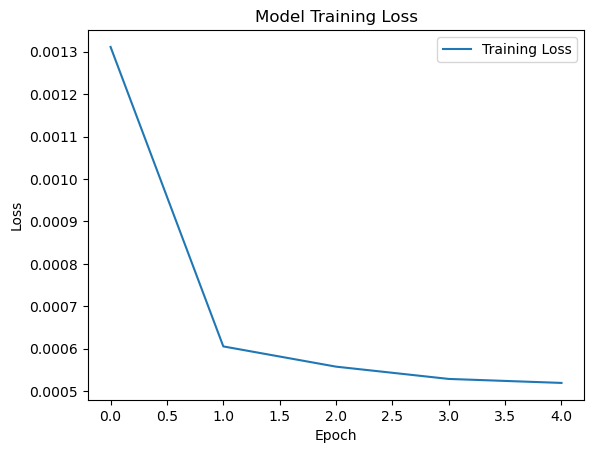

In [51]:
# Plot loss trajectory across epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


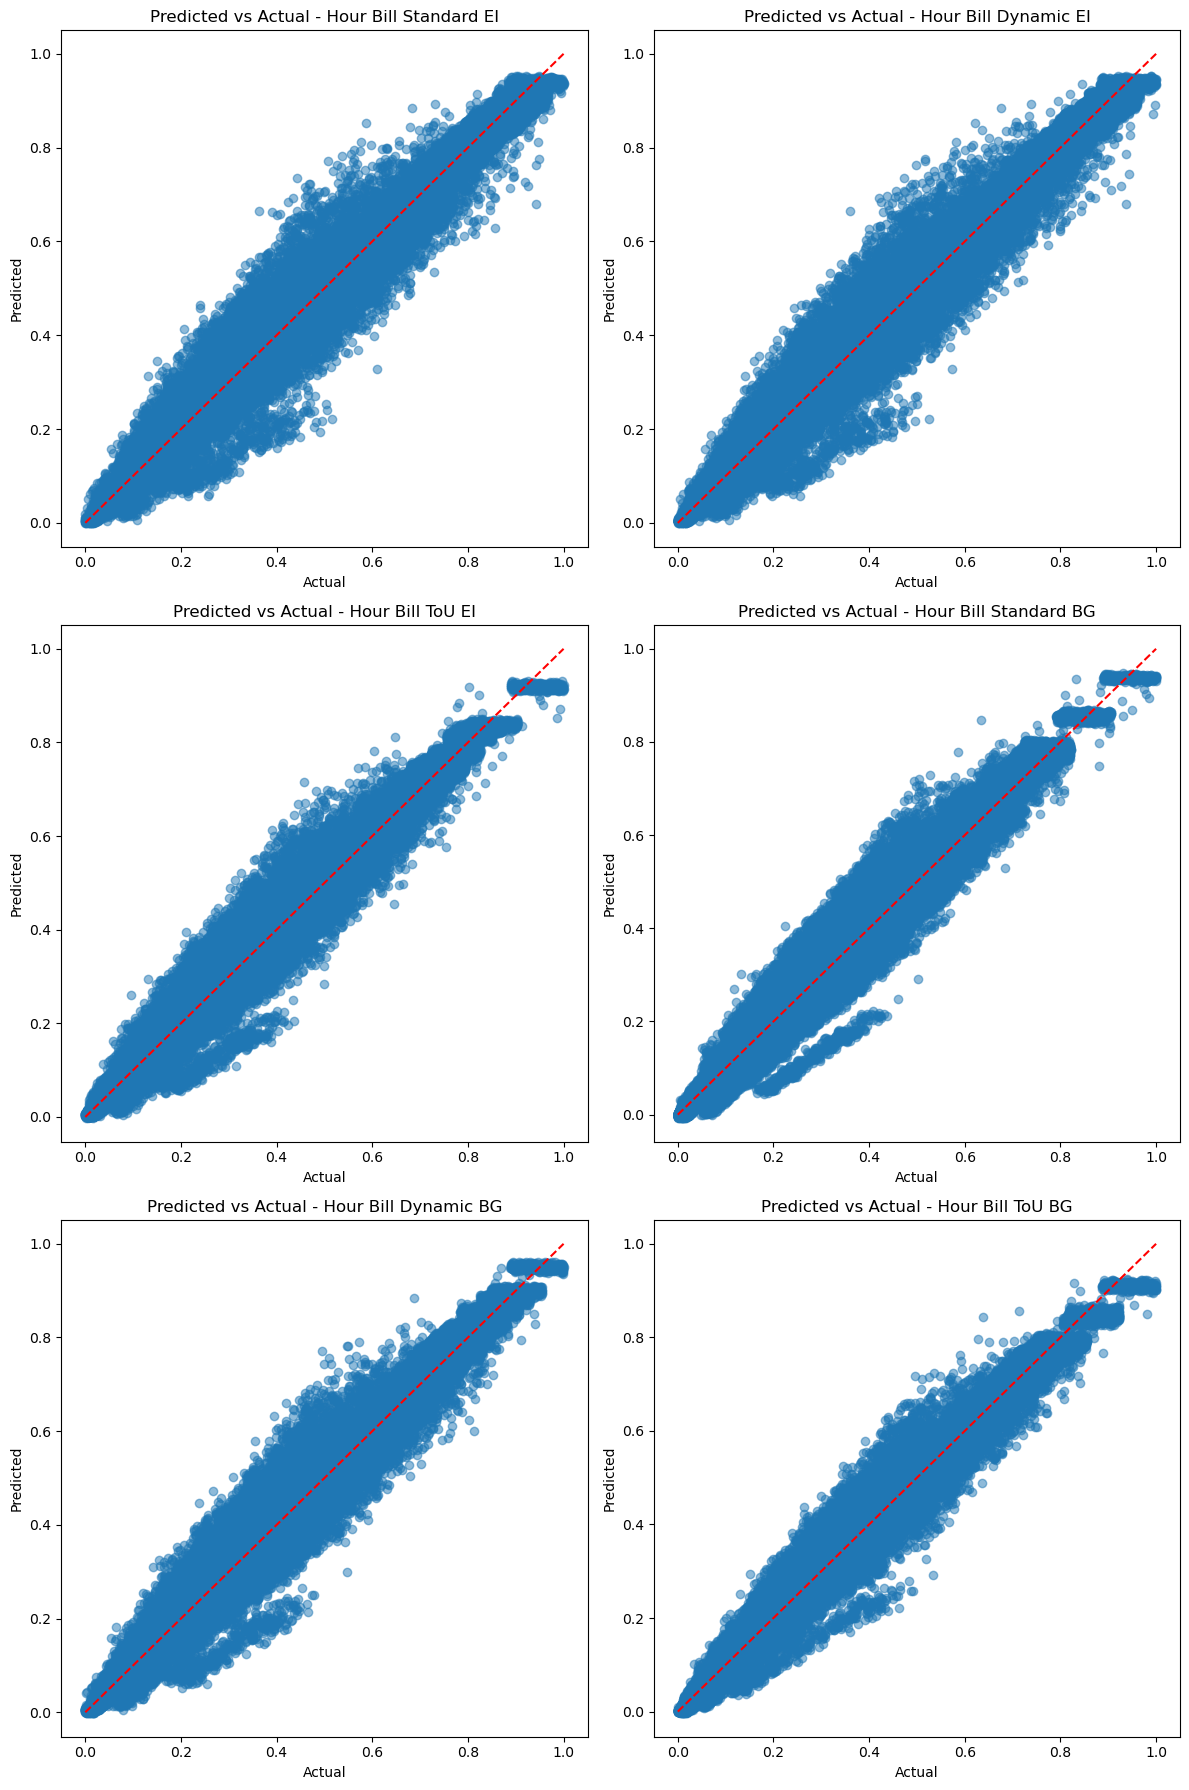

In [10]:
# Get actual values from the data for the target columns (the last columns in the dataset)
# We will align the actual values corresponding to the prediction sequences
actual_bills = df[targets].iloc[SEQ_LENGTH:].to_numpy()

# Get the predictions from the generator's output (2D array of predictions)
predictions_last = predictions  # No need to index with [-1, :], predictions are already 2D

# Ensure both have the same size for comparison
assert actual_bills.shape == predictions_last.shape, "Shapes of actual bills and predictions do not match!"

# Plot Predicted vs Actual Bill Values
plt.figure(figsize=(12, 18))

# Loop over each target and create a scatter plot
for i, target in enumerate(targets):
    plt.subplot(3, 2, i+1)
    plt.scatter(actual_bills[:, i], predictions_last[:, i], alpha=0.5)
    plt.plot([actual_bills[:, i].min(), actual_bills[:, i].max()],
             [actual_bills[:, i].min(), actual_bills[:, i].max()],
             '--r')
    plt.title(f'Predicted vs Actual - {target}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

plt.tight_layout()
plt.show()
